In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as inte

In [2]:
def trajSin(t):
    return np.array([np.cos(np.pi*t),np.sin(np.pi*t)])

def trajSquare(t):
    spd = .2
    if t<2.5:
        x = np.array([.5,0])+spd*np.array([-1,1])*t
    elif t<5:
        x = np.array([0,.5])+spd*np.array([-1,-1])*(t-2.5)
    elif t<7.5:
        x = np.array([-.5,0])+spd*np.array([1,-1])*(t-5)
    else:
        x = np.array([0,-.5])+spd*np.array([1,1])*(t-7.5)
        
    return x

### State-space

\begin{align}
x &= \left[\begin{array}{c}x_1\\x_2\\x_3\\x_4\end{array}\right] = \left[\begin{array}{c}\theta_1\\ \theta_2\\ \dot{\theta_1}\\ \dot{\theta_2}\end{array}\right] \\
\dot{x} &= \left[\begin{array}{c}\dot{\theta_1}\\ \dot{\theta_2}\\\ddot{\theta_1}\\ \ddot{\theta_2}\end{array}\right] =\\
&\left[\begin{array}{c}\dot{\theta_1}\\ \dot{\theta_2}\\ \frac{-u_1+u_2-2glmc_{\theta_1}+u_2c_{\theta_2}+glmc_{\theta_2}c_{\theta_1+\theta_2}+2\dot{\theta_1}\dot{\theta_2}l^2ms_{\theta_2}+(\dot{\theta_2}l)^2ms_{\theta_2}+(\dot{\theta_1} l)^2ms_{\theta_2}(1+c_{\theta_2})}{ml^2(2-c_{\theta_2})} \\ \frac{-u_1+3u_2-2glmc_{\theta_1}-u_1c_{\theta_2}+2u_2c_{\theta_2}-2glmc_{\theta_2}c_{\theta_1}+2glmc_{\theta_1+\theta_2}+glmc_{\theta_2}c_{\theta_1+\theta_2}+(\dot{\theta_2}l)^2m(1+c_{\theta_2})s_{\theta_2}+\dot{\theta_1}\dot{\theta_2}l^2m\csc^2(\frac{\theta_2}{2})s^3_{\theta_2}+(\dot{\theta_1}l)^2m(3s_{\theta_2}+s_{2\theta_2})}{ml^2(2-\cos(\theta_2))} \end{array}\right] 
\end{align}

### PD Control

\begin{align}
p &= l\left[\begin{array}{c}c_{\theta_1}+c_{\theta_1+\theta_2}\\ s_{\theta_1}+s_{\theta_1+\theta_2}\end{array}\right] \\
e &= p-p_d\\
J &= l\left[\begin{array}{cc}-s_{\theta_1}-s_{\theta_1+\theta_2}&-s_{\theta_1+\theta_2}\\c_{\theta_1}+c_{\theta_1+\theta_2}&c_{\theta_1+\theta_2}\end{array}\right] \\
u &= -k_pJ^\top e-k_d\left[\begin{array}{c}\dot{\theta_1}\\ \dot{\theta_2}\end{array}\right]
\end{align} 

In [3]:
def controller(params,t,X):
    l,kp,kd = .5,30000,100
    p = l*np.array([[np.cos(X[0])+np.cos(X[0]+X[1])],
                    [np.sin(X[0])+np.sin(X[0]+X[1])]])
    e = p.reshape(1,-1)-params['traj'](t)
    J = l*np.array([[-np.sin(X[0])-np.sin(X[0]+X[1]),-np.sin(X[0]+X[1])],
                    [np.cos(X[0])+np.cos(X[0]+X[1]),np.cos(X[0]+X[1])]])
    u = -1*kp*np.matmul(J.T,e.reshape(-1,1)).T-kd*X[2:]
    return u

In [4]:
def robotSIm(traj):
    params = {}; params['m'] = 1
    params['g'] = 9.81; params['l'] = .5
    params['traj'] = traj
    t0,t1 = 0,10; t = np.linspace(0,10,250)
    y0 = np.array([0,1,0,0]); y = np.zeros((len(t),len(y0)))
    y[0,:] = y0
    r = inte.ode(lambda t,y:dynamics(params,t,y)).set_integrator("dopri5") 
    r.set_initial_value(y0, t0)   # initial values
    for i in range(1, t.size):
        y[i, :] = r.integrate(t[i]) # get one more value, add it to the array
        if not r.successful():
           raise RuntimeError("Could not integrate")
    
    return t,y

In [5]:
def dynamics(params,t,X):
    Xd = np.zeros(X.shape)
    th1,th2,dth1,dth2 = X[0],X[1],X[2],X[3]
    
    u = controller(params,t,X)
    u1,u2 = -u[0,0],u[0,1]
    m,l,g = params['m'],params['l'],params['g']
    
    Xd[:2] = X[2:]
    a=-u1+u2-2*g*l*m*np.cos(th1)+u2*np.cos(th2)+g*l*m*np.cos(th2)*np.cos(th1+th2)
    b=2*dth1*dth2*l**2*m*np.sin(th2)+(dth2*l)**2*m*np.sin(th2)+(dth1*l)**2*m*(1+np.cos(th2))*np.sin(th2)
    c=(2-np.cos(th2))*m*l**2
    d=-u1+3*u2-2*g*l*m*np.cos(th1)-u1*np.cos(th2)+u2*np.cos(th2)-2*g*l*m*np.cos(th1)*np.cos(th2)
    e=2*g*l*m*np.cos(th1+th2)+g*l*m*np.cos(th2)*np.cos(th1+th2)+(dth2*l)**2*m*(1+np.cos(th2))*np.sin(th2)
    f=dth1*dth2*l**2*m/np.sin(th2/2)**2*np.sin(th2)**3+(dth1*l)**2*m*(3*np.sin(th2)+np.sin(2*th2))
    tmp1 = (a+b)/c
    tmp2 = (d+e+f)/c
    Xd[2:] = np.array([tmp1,tmp2])
        
    return Xd

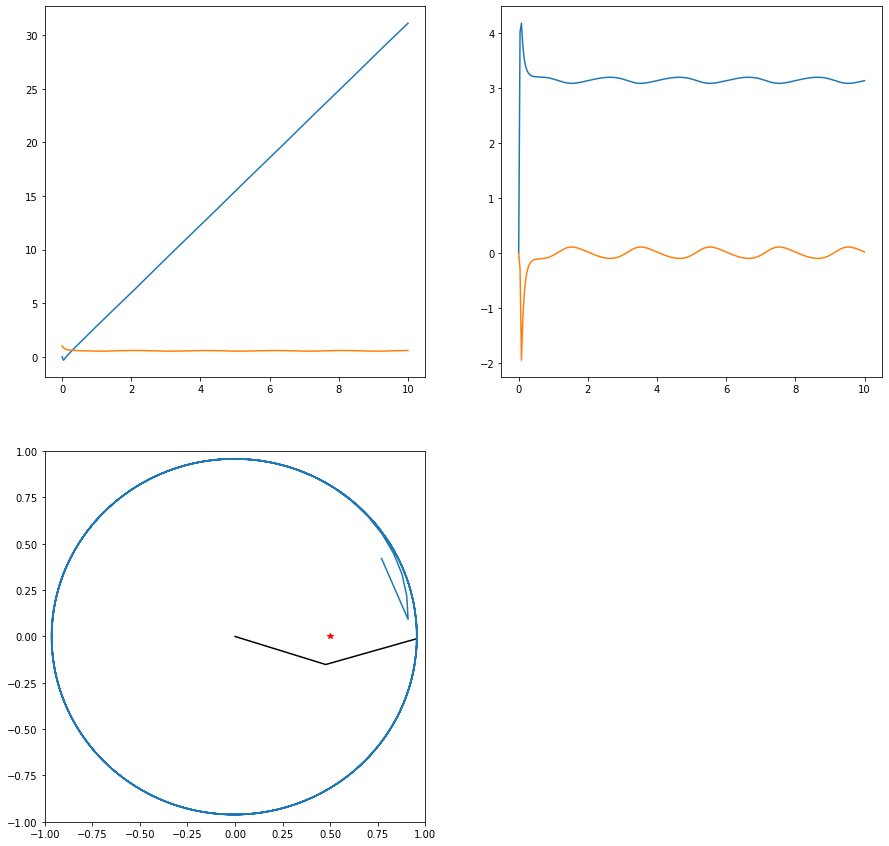

In [6]:
t,y = robotSIm(lambda t:trajSin(t))
th1 = y[:,0]
th2 = y[:,1]
p1 = .5*np.array([np.cos(th1),np.sin(th1)])
p2 = p1+.5*np.array([np.cos(th1+th2),np.sin(th1+th2)])

fig = plt.figure(figsize=(15,15))

ax = plt.subplot(2,2,1)
plt.plot(t,y[:,0])
plt.plot(t,y[:,1])
ax = plt.subplot(2,2,2)
plt.plot(t,y[:,2])
plt.plot(t,y[:,3])

i = -1
ax = plt.subplot(2,2,3)
plt.ylim([-1,1]); plt.xlim([-1,1])
ax.plot(np.array([0,p1[0,i],p2[0,i]]),
       np.array([0,p1[1,i],p2[1,i]]),'k-')
ax.plot(p2[0,:i],p2[1,:i])
trajNow = trajSquare(t[i])
ax.plot(trajNow[0],trajNow[1],'r*')

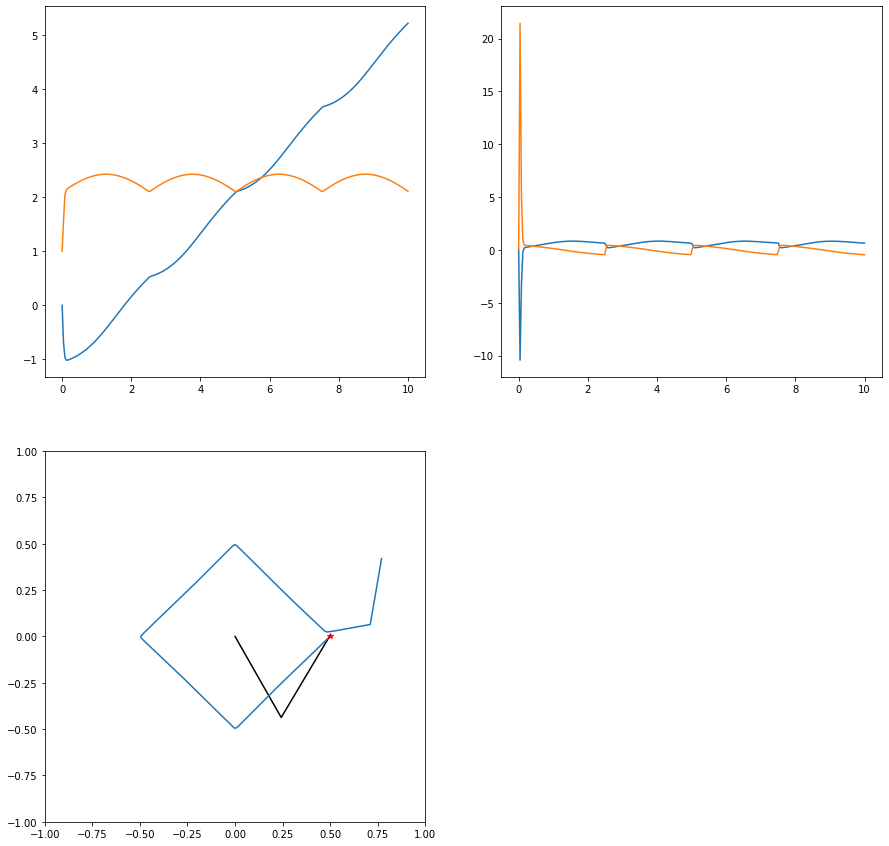

In [7]:
t,y = robotSIm(lambda t:trajSquare(t))
th1 = y[:,0]
th2 = y[:,1]
p1 = .5*np.array([np.cos(th1),np.sin(th1)])
p2 = p1+.5*np.array([np.cos(th1+th2),np.sin(th1+th2)])

fig = plt.figure(figsize=(15,15))

ax = plt.subplot(2,2,1)
plt.plot(t,y[:,0])
plt.plot(t,y[:,1])
ax = plt.subplot(2,2,2)
plt.plot(t,y[:,2])
plt.plot(t,y[:,3])

i = -1
ax = plt.subplot(2,2,3)
plt.ylim([-1,1]); plt.xlim([-1,1])
ax.plot(np.array([0,p1[0,i],p2[0,i]]),
       np.array([0,p1[1,i],p2[1,i]]),'k-')
ax.plot(p2[0,:i],p2[1,:i])
trajNow = trajSquare(t[i])
ax.plot(trajNow[0],trajNow[1],'r*')